In [1]:
import os
import pickle

from source.source.path_config import REPOSITORY_ROOT
from source.source.data_utils import load_dict
from source.datasets.constants import DatasetName

from source.metrics.create_specific_risks import get_risk_approximation
from source.metrics.constants import GName
from source.metrics.constants import RiskType
from source.metrics.constants import ApproximationType

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# filepath = os.path.join(
#     REPOSITORY_ROOT,
#     "external_repos/pytorch_cifar10/checkpoints/resnet18/CENTRAL_extracted_information_for_notebook_combinations.pkl",
# )

filepath = os.path.join(
    REPOSITORY_ROOT,
    # f"torch_uncertainty_models/logits/{DatasetName.CIFAR10.value}_CENTRAL_extracted_information_for_notebook_combinations.pkl",
    f"external_repos/pytorch_cifar10/checkpoints/resnet18/{DatasetName.CIFAR10.value}_CENTRAL_extracted_information_for_notebook_combinations.pkl",
    # f"external_repos/pytorch_cifar100/checkpoints/resnet18/{DatasetName.CIFAR100.value}_CENTRAL_extracted_information_for_notebook_combinations.pkl",
)

In [3]:
res = load_dict(filepath)

In [4]:
# T = 2.
T = 1.0

In [5]:
res.keys()

dict_keys(['uq_results', 'embeddings_per_dataset', 'targets_per_dataset'])

In [6]:
ind_logits = res['embeddings_per_dataset']['CrossEntropy'][DatasetName.CIFAR10.value] / T
ood_logits = res['embeddings_per_dataset']['CrossEntropy'][DatasetName.SVHN.value] / T

# ind_logits = (
#     res["embeddings_per_dataset"]["CrossEntropy"][DatasetName.TINY_IMAGENET.value] / T
# )
# ood_logits = (
#     res["embeddings_per_dataset"]["CrossEntropy"][DatasetName.IMAGENET_O.value] / T
# )

In [7]:
from scipy.special import softmax

In [8]:
ind_logits.shape

(20, 10000, 10)

In [9]:
ind_probs = softmax(ind_logits, axis=-1)
ood_probs = softmax(ood_logits, axis=-1)

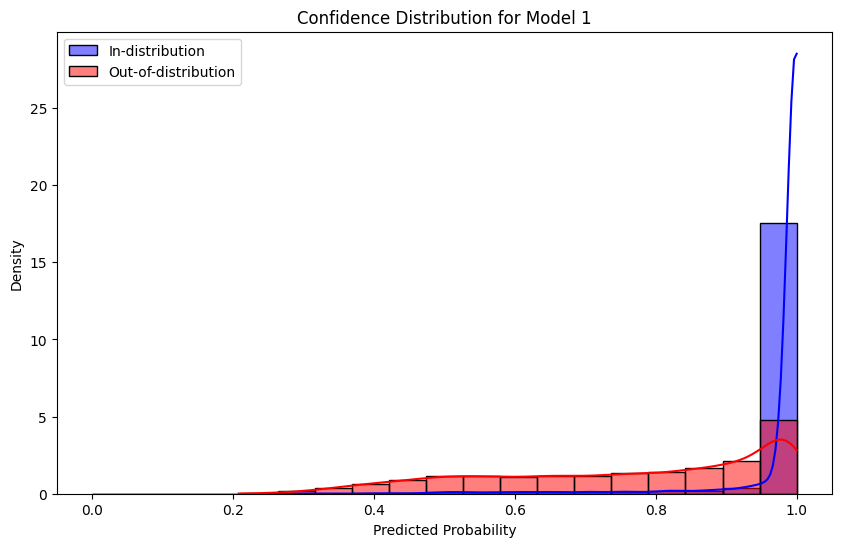

In [10]:
model_index = 1

in_probs_flat = ind_probs[model_index].max(-1).flatten()
out_probs_flat = ood_probs[model_index].max(-1).flatten()

# Step 4: Plot histograms
bins = np.linspace(start=0.0, stop=1.0, num=20)
plt.figure(figsize=(10, 6))
sns.histplot(
    in_probs_flat,
    color="blue",
    label="In-distribution",
    kde=True,
    stat="density",
    bins=bins,
    alpha=0.5,
)
sns.histplot(
    out_probs_flat,
    color="red",
    label="Out-of-distribution",
    kde=True,
    stat="density",
    bins=bins,
    alpha=0.5,
)
plt.title(f"Confidence Distribution for Model {model_index}")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

In [11]:
ind_exc = get_risk_approximation(
    g_name=GName.LOG_SCORE,
    risk_type=RiskType.EXCESS_RISK,
    logits=ind_logits,
    gt_approx=ApproximationType.OUTER,
    pred_approx=ApproximationType.OUTER,
    T=T,
)

ood_exc = get_risk_approximation(
    g_name=GName.LOG_SCORE,
    risk_type=RiskType.EXCESS_RISK,
    logits=ood_logits,
    gt_approx=ApproximationType.OUTER,
    pred_approx=ApproximationType.OUTER,
    T=T,
)


ind_b = get_risk_approximation(
    g_name=GName.LOG_SCORE,
    risk_type=RiskType.BAYES_RISK,
    logits=ind_logits,
    gt_approx=ApproximationType.OUTER,
    pred_approx=ApproximationType.OUTER,
    T=T,
)

ind_b_inner = get_risk_approximation(
    g_name=GName.LOG_SCORE,
    risk_type=RiskType.BAYES_RISK,
    logits=ind_logits,
    gt_approx=ApproximationType.INNER,
    pred_approx=ApproximationType.INNER,
    T=T,
)


ood_b = get_risk_approximation(
    g_name=GName.LOG_SCORE,
    risk_type=RiskType.BAYES_RISK,
    logits=ood_logits,
    gt_approx=ApproximationType.OUTER,
    pred_approx=ApproximationType.OUTER,
    T=T,
)

ood_b_inner = get_risk_approximation(
    g_name=GName.LOG_SCORE,
    risk_type=RiskType.BAYES_RISK,
    logits=ood_logits,
    gt_approx=ApproximationType.INNER,
    pred_approx=ApproximationType.INNER,
    T=T,
)

In [12]:
ood_b

array([0.9029366, 0.6250187, 0.676184 , ..., 1.1031199, 1.0272254,
       0.7840858], dtype=float32)

In [13]:
ood_b_inner

array([1.2622753, 1.0545715, 1.2183914, ..., 1.5362052, 1.512836 ,
       1.1398896], dtype=float32)

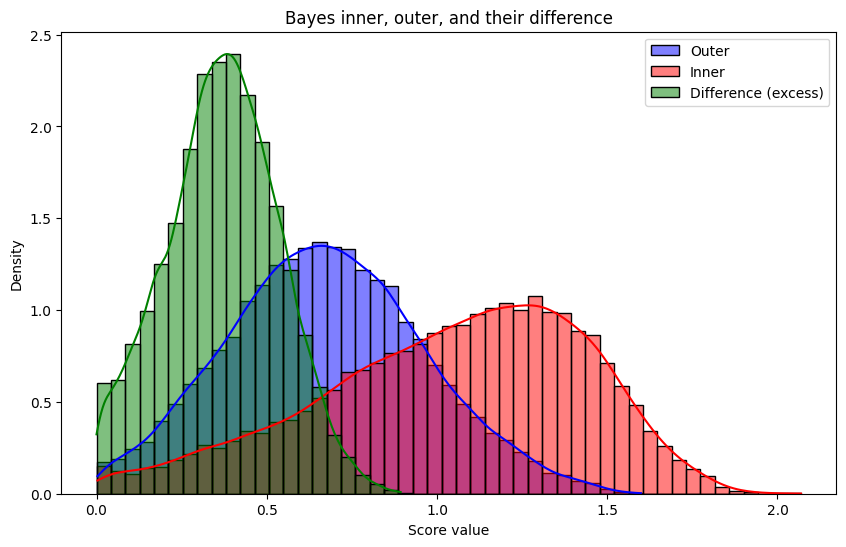

In [14]:
bins = np.linspace(start=0, stop=np.max(ood_b_inner), num=50)

plt.figure(figsize=(10, 6))
sns.histplot(
    ood_b, color="blue", label="Outer", kde=True, stat="density", bins=bins, alpha=0.5
)
sns.histplot(
    ood_b_inner,
    color="red",
    label="Inner",
    kde=True,
    stat="density",
    bins=bins,
    alpha=0.5,
)
sns.histplot(
    ood_b_inner - ood_b,
    color="green",
    label="Difference (excess)",
    kde=True,
    stat="density",
    bins=bins,
    alpha=0.5,
)
plt.title("Bayes inner, outer, and their difference")
plt.xlabel("Score value")
plt.ylabel("Density")
plt.legend()
plt.show()

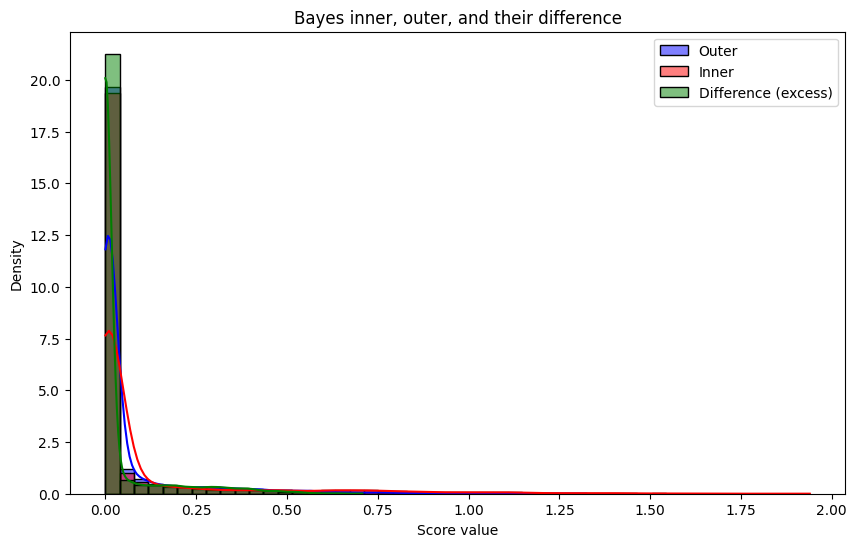

In [15]:
bins = np.linspace(start=0, stop=np.max(ind_b_inner), num=50)

plt.figure(figsize=(10, 6))
sns.histplot(
    ind_b, color="blue", label="Outer", kde=True, stat="density", bins=bins, alpha=0.5
)
sns.histplot(
    ind_b_inner,
    color="red",
    label="Inner",
    kde=True,
    stat="density",
    bins=bins,
    alpha=0.5,
)
sns.histplot(
    ind_b_inner - ind_b,
    color="green",
    label="Difference (excess)",
    kde=True,
    stat="density",
    bins=bins,
    alpha=0.5,
)
plt.title("Bayes inner, outer, and their difference")
plt.xlabel("Score value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [16]:
ind_exc.shape

(10000,)

In [17]:
ood_exc.shape

(26032,)

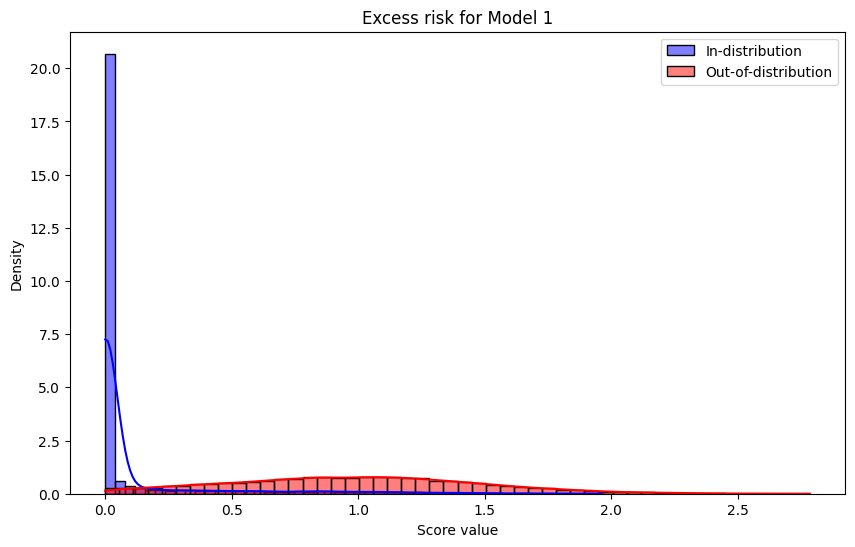

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(
    ind_exc,
    color="blue",
    label="In-distribution",
    kde=True,
    stat="density",
    bins=50,
    alpha=0.5,
)
sns.histplot(
    ood_exc,
    color="red",
    label="Out-of-distribution",
    kde=True,
    stat="density",
    bins=50,
    alpha=0.5,
)
plt.title(f"Excess risk for Model {model_index}")
plt.xlabel("Score value")
plt.ylabel("Density")
plt.legend()
plt.show()

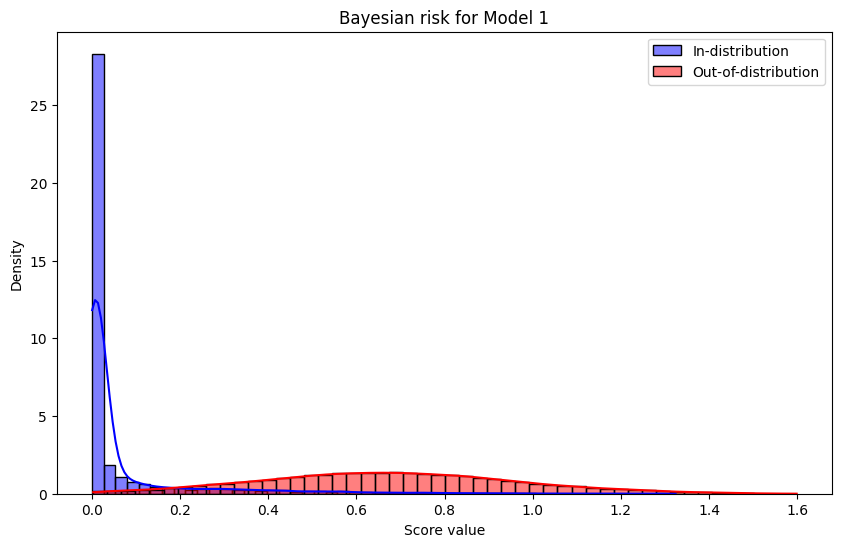

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(
    ind_b,
    color="blue",
    label="In-distribution",
    kde=True,
    stat="density",
    bins=50,
    alpha=0.5,
)
sns.histplot(
    ood_b,
    color="red",
    label="Out-of-distribution",
    kde=True,
    stat="density",
    bins=50,
    alpha=0.5,
)
plt.title(f"Bayesian risk for Model {model_index}")
plt.xlabel("Score value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [6]:
import numpy as np

In [7]:
ind_medians = np.median(ind_probs, axis=(0, 1))

NameError: name 'ind_probs' is not defined

In [8]:
ood_medians = np.median(ood_probs, axis=(0, 1))

NameError: name 'ood_probs' is not defined

In [9]:
ind_medians

NameError: name 'ind_medians' is not defined

In [21]:
ood_medians

array([0.00207027, 0.00139642, 0.00636799, 0.01002525, 0.0023474 ,
       0.00180358, 0.00328116, 0.00160779, 0.00207039, 0.00224724],
      dtype=float32)

In [2]:
T = 1.0

In [35]:
ind_logits_path = os.path.join(
    REPOSITORY_ROOT,
    "torch_uncertainty_models/logits/tiny_imagenet/0/tiny_imagenet.pkl",
)

ood_logits_path = os.path.join(
    REPOSITORY_ROOT,
    "torch_uncertainty_models/logits/tiny_imagenet/0/imagenet_r.pkl",
)

In [36]:
ind_logits = load_dict(ind_logits_path)
ood_logits = load_dict(ood_logits_path)

In [37]:
np.mean(np.argmax(ind_logits["embeddings"], axis=-1) == ind_logits["labels"])

0.6261

In [38]:
ind_exc = get_risk_approximation(
    g_name=GName.LOG_SCORE,
    risk_type=RiskType.EXCESS_RISK,
    logits=ind_logits["embeddings"][None],
    gt_approx=ApproximationType.OUTER,
    pred_approx=ApproximationType.OUTER,
    T=T,
)

ood_exc = get_risk_approximation(
    g_name=GName.LOG_SCORE,
    risk_type=RiskType.EXCESS_RISK,
    logits=ood_logits["embeddings"][None],
    gt_approx=ApproximationType.OUTER,
    pred_approx=ApproximationType.OUTER,
    T=T,
)

ind_b = get_risk_approximation(
    g_name=GName.LOG_SCORE,
    risk_type=RiskType.BAYES_RISK,
    logits=ind_logits["embeddings"][None],
    gt_approx=ApproximationType.OUTER,
    pred_approx=ApproximationType.OUTER,
    T=T,
)

ood_b = get_risk_approximation(
    g_name=GName.LOG_SCORE,
    risk_type=RiskType.BAYES_RISK,
    logits=ood_logits["embeddings"][None],
    gt_approx=ApproximationType.OUTER,
    pred_approx=ApproximationType.OUTER,
    T=T,
)

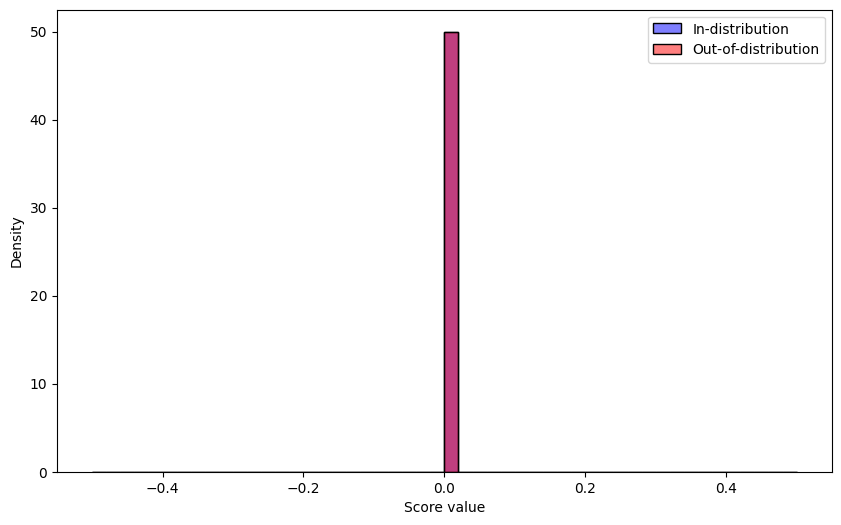

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(
    ind_exc,
    color="blue",
    label="In-distribution",
    kde=True,
    stat="density",
    bins=50,
    alpha=0.5,
)
sns.histplot(
    ood_exc,
    color="red",
    label="Out-of-distribution",
    kde=True,
    stat="density",
    bins=50,
    alpha=0.5,
)
# plt.title(f'Excess risk for Model {model_index}')
plt.xlabel("Score value")
plt.ylabel("Density")
plt.legend()
plt.show()

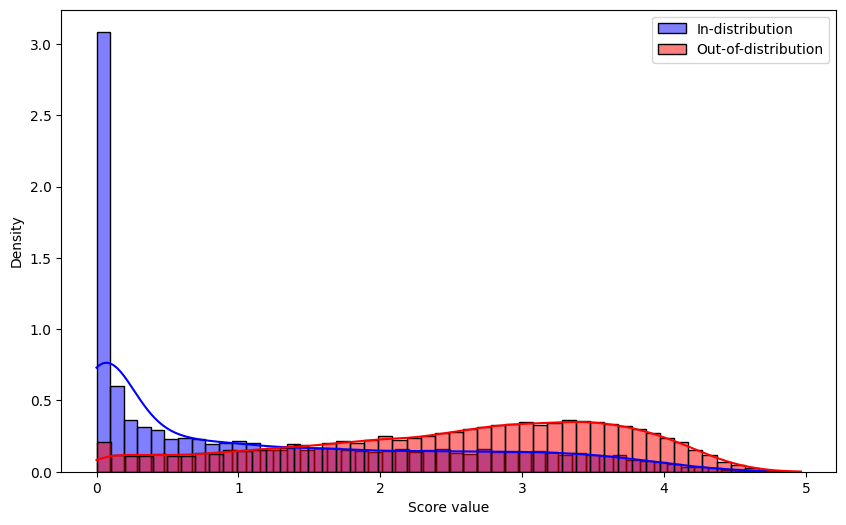

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(
    ind_b,
    color="blue",
    label="In-distribution",
    kde=True,
    stat="density",
    bins=50,
    alpha=0.5,
)
sns.histplot(
    ood_b,
    color="red",
    label="Out-of-distribution",
    kde=True,
    stat="density",
    bins=50,
    alpha=0.5,
)
# plt.title(f'Excess risk for Model {model_index}')
plt.xlabel("Score value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import roc_auc_score

In [42]:
labels = np.hstack([np.ones_like(ood_b), np.zeros_like(ind_b)])
scores = np.hstack([ood_b, ind_b])

In [43]:
roc_auc_score(y_true=labels, y_score=scores)

0.7823776549999999